In [259]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy

In [461]:
iter = 0

x_0 = 0 # [m] starting horizontal coordinate
z_0 = 100 # [m] starting vertical coordinate
theta_0 = 15 * np.pi/180 # [rad] starting angle from the horizontal (+ in the +z direction)
t_0 = 0 # [s] initial time
dt = 1e-3 # [s] time interval
dz = 1e-2 # [m] vertical increment for differentiation

z = np.array([z_0], dtype = np.float64) # [m] vertical coordinates
x = np.array([x_0], dtype = np.float64) # [m] horizontal coordinates
theta = np.array([theta_0], dtype = np.float64) # [rad] launch angle
t = np.linspace(0,100,1) # [s] array of time steps

ssp_filename = '/Users/matthewaidan/Documents/pythonscripts/acoustic-models/SSP_USGS/2017-002-FA_CTD24.svp'
try:
    with open(ssp_filename, 'r') as file:
        content = file.read()
        content = content.split('\n')[3:-1]
        content = [item.split(' ') for item in content]
        converted_list = np.array([[float(item) for item in sublist] for sublist in content])
        z_ssp = converted_list[:,0] # [m] corresponding vertical coordinates for ssp
        ssp = converted_list[:,1] # [m/s] sound speed profile, https://doi.org/10.5066/P9Y1MSTN
except FileNotFoundError:
    print(f"Error: {file} was not found.", file = ssp_filename)

ssp_cs = scipy.interpolate.CubicSpline(z_ssp, ssp)
# each step will be equivalent in time

while iter < 1000:

    # get sound speed, sound speed gradient, and curvature @ initial point
    c = ssp_cs(z[iter])
    g = (ssp_cs(z[iter] + dz) - ssp_cs(z[iter]))/dz
    R = -(1/g)*(c/np.cos(theta[iter]))

    # prepare next step in history of travel path
    theta = np.append(theta, 0)
    z = np.append(z, 0)
    x = np.append(x, 0)

    # populate next step in history of travel path
    theta[iter + 1] = theta[iter] - (c * dt)/R

    dz = R * (np.cos(theta[iter + 1]) - np.cos(theta[iter]))
    dx = R * (np.sin(theta[iter + 1]) - np.sin(theta[iter]))

    z[iter + 1] = z[iter] + dz
    x[iter + 1] = x[iter] + dx

    if z[iter + 1] < 0: 
        
        # switch the direction of theta to simulate bounce off ssb
        theta_turn = -np.arccos(z[iter]/R + np.cos(theta[iter])) 
        x[iter + 1] = x[iter] + R * (np.sin(theta[iter]) - np.sin(-theta_turn))
        dt_portion = (R * -1*(theta[iter] + theta_turn))/c
        
        theta[iter + 1] = theta[iter] - (c * (dt - dt_portion))/R
        z[iter + 1] = 0 - R * (np.cos(theta[iter + 1]) - np.cos(theta[iter]))
        x[iter + 1] = x[iter] + R * (np.sin(theta[iter]) - np.sin(theta[iter + 1]))
    
    iter += 1

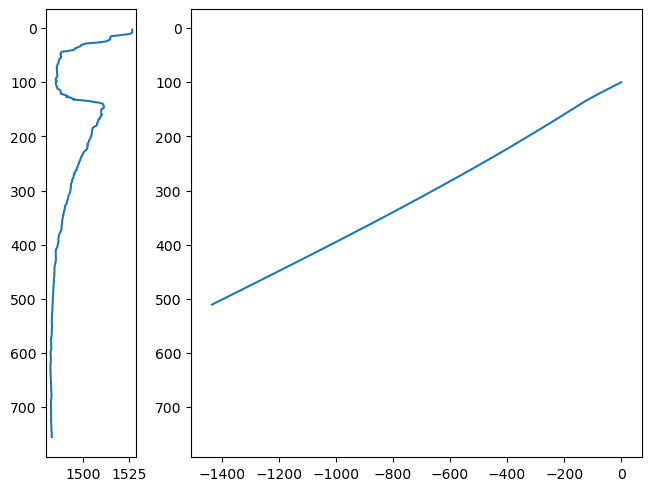

In [463]:
fig = plt.figure(layout="constrained") 
gs = gridspec.GridSpec(nrows=3, ncols=6, figure=fig) 

ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[:,1:])

ax1.plot(ssp, z_ssp)
ax1.invert_yaxis()
zlims = ax1.get_ylim

ax2.plot(x, z)
ax2.set_ylim(ax1.get_ylim()[::-1])
ax2.invert_yaxis()

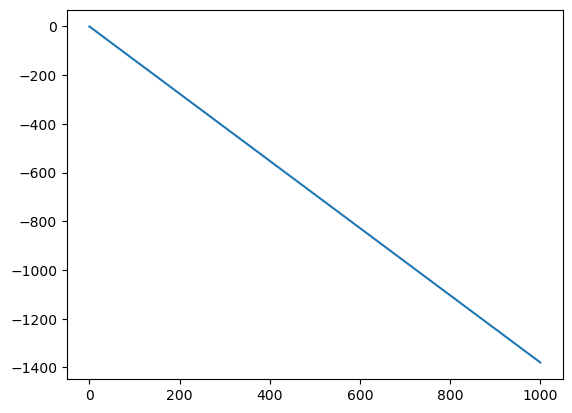

In [455]:
plt.plot(x)